In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from hGLM_class import hGLM
from sklearn import metrics

# Hyperparams

In [2]:
train_T = 20000
test_T = 8000
B = 251
C_den = torch.Tensor([0]).reshape((1,1))
M = 1

batch_size = 8192

In [3]:
Ensyn = torch.tensor([629])
Insyn = torch.tensor([120])

N = Ensyn.item() + Insyn.item()

"""
G = torch.zeros(N)
G[Ensyn] = 2
G[Ensyn+1:] = 1
"""
synlocs = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/synlocs_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.npy")
G = torch.zeros(synlocs.shape[0])
for i in range(G.shape[0]):
    loc = synlocs[i,1]
    if loc < 1/3:
        G[i] = 0
    elif loc == 1.5:
        G[i] = 6
    elif (loc >= 1/3) & (loc < 2/3):
        G[i] = 1
    elif (loc >= 2/3) & (loc < 1):
        G[i] = 2
    elif (loc >= 1) & (loc < 4/3):
        G[i] = 3
    elif (loc >= 4/3) & (loc < 5/3):
        G[i] = 4
    elif (loc >= 5/3) & (loc < 2):
        G[i] = 5



C_syn = torch.zeros(M, N)
count = 0
for m in range(M):
    for e in range(Ensyn[m]):
        C_syn[m,count] = 1
        count += 1
        
for m in range(M):
    for i in range(Insyn[m]):
        C_syn[m,count] = -1
        count += 1

# Initialize

In [4]:
fit_hGLM = hGLM(C_den, C_syn, B, G, Ensyn).cuda()

In [5]:
V_ref = np.fromfile("/media/hdd01/sklee/hglm/biophysical/inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")
V_ref = V_ref[1:-2]

train_V_ref = V_ref[B:train_T - batch_size +B]
test_V_ref = V_ref[train_T:train_T+test_T]

In [6]:
E_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")

train_neural = np.hstack((E_neural, I_neural))[:train_T]
test_neural = np.hstack((E_neural, I_neural))[train_T:train_T + test_T]
train_neural = torch.from_numpy(train_neural)
test_neural = torch.from_numpy(test_neural).cuda()

# Fill out Init V outputs
train_V_init = np.empty((train_T - batch_size))
for i in tnrange(train_V_init.shape[0]):
    batch_X = train_neural[i:i+batch_size].float().cuda()
    batch_V = fit_hGLM(batch_X)
    train_V_init[i] = batch_V[B].item()
    
test_V_init = fit_hGLM(test_neural.float())
test_V_init = test_V_init.cpu().detach().numpy()

<ipython-input-6-4f68a5138d6a>:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(train_V_init.shape[0]):


0.11239416821958181
0.12552498114299426
0.45049233160826535
0.6468650902796538


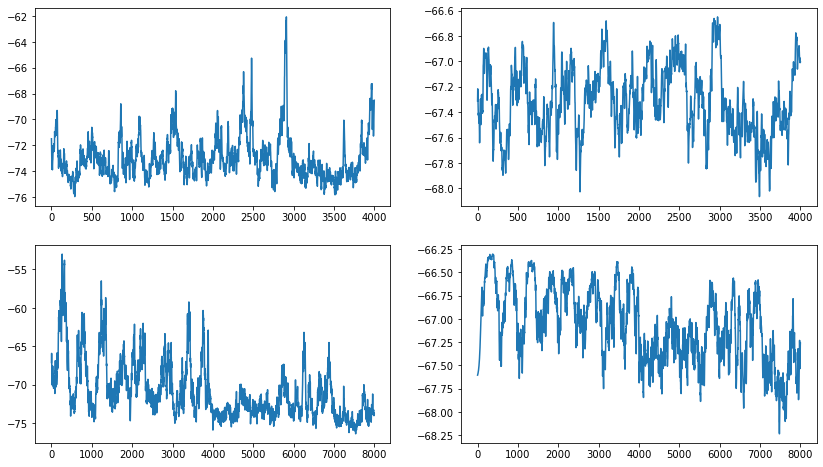

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (14,8))
axs[0,0].plot(train_V_ref[1000:5000])
axs[1,0].plot(test_V_ref)
axs[0,1].plot(train_V_init[1000:5000])
axs[1,1].plot(test_V_init)

print(metrics.explained_variance_score(y_true=train_V_ref, y_pred=train_V_init, multioutput='uniform_average'))
print(metrics.explained_variance_score(y_true=test_V_ref, y_pred=test_V_init, multioutput='uniform_average'))

print(np.corrcoef(train_V_ref, train_V_init)[0][1])
print(np.corrcoef(test_V_ref, test_V_init)[0][1])

In [9]:
#np.save("/media/hdd01/sklee/hglm/biophysical/train_V_ref.npy", train_V_ref)
np.save("/media/hdd01/sklee/hglm/biophysical/test_V_ref.npy", test_V_ref)
#np.save("/media/hdd01/sklee/hglm/biophysical/pre_fit/train_V_init.npy", train_V_init)
np.save("/media/hdd01/sklee/hglm/biophysical/pre_fit/test_V_init.npy", test_V_init)

np.save("/media/hdd01/sklee/hglm/biophysical/pre_fit/pre_C_den.npy", C_den.cpu().detach().numpy())
np.save("/media/hdd01/sklee/hglm/biophysical/pre_fit/pre_C_syn.npy", C_syn.cpu().detach().numpy())

torch.save(fit_hGLM.state_dict(), "/media/hdd01/sklee/hglm/biophysical/pre_fit/hglm_init.pt")

# Pre-Fit on 1 Subunit (1 E,I Kernel)

In [4]:
C_den = np.load("/media/hdd01/sklee/hglm/biophysical/pre_fit/pre_C_den.npy")
C_syn = np.load("/media/hdd01/sklee/hglm/biophysical/pre_fit/pre_C_syn.npy")
C_den = torch.from_numpy(C_den)
C_syn = torch.from_numpy(C_syn)

fit_hGLM = hGLM(C_den, C_syn, B, G, Ensyn).cuda()
fit_hGLM.load_state_dict(torch.load("/media/hdd01/sklee/hglm/biophysical/pre_fit/hglm_init.pt"))
fit_hGLM.train()

test_V_ref = np.load("/media/hdd01/sklee/hglm/biophysical/test_V_ref.npy")[:]
test_V_ref = torch.from_numpy(test_V_ref).cuda()

train_V_ref = np.fromfile("/media/hdd01/sklee/hglm/biophysical/inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")[1:-2][:train_T]
train_V_ref = torch.from_numpy(train_V_ref)

In [5]:
E_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")

train_neural = np.hstack((E_neural, I_neural))[:train_T]
test_neural = np.hstack((E_neural, I_neural))[train_T:train_T + test_T]
train_neural = torch.from_numpy(train_neural)
test_neural = torch.from_numpy(test_neural).cuda()


In [6]:
repeat_no = 2
batch_no = (train_V_ref.shape[0]) * 2
train_idx = np.empty((repeat_no, train_V_ref.shape[0]))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0])
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)

40000


In [7]:

fit_hGLM.Theta.requires_grad = True
fit_hGLM.W.requires_grad = True
fit_hGLM.Delta.requires_grad = True
fit_hGLM.V_o.requires_grad = True
fit_hGLM.C.requires_grad= True
fit_hGLM.Tau.requires_grad= True
#fit_hGLM.Tau_ratio.requires_grad= True


In [8]:
optimizer = optim.Adam(fit_hGLM.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, 10000, gamma=0.5)


In [9]:
loss_array = np.empty((batch_no))

for i in tnrange(batch_no):
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_X = train_neural[batch_idx : batch_idx+batch_size].float().cuda()
    batch_pred = fit_hGLM(batch_X)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].cuda()
    
    #loss = criterion(batch_ref, batch_pred)
    
    diff = (batch_ref - batch_pred) ** 1
    loss = torch.var(diff)
    loss_array[i] = loss.item()
    
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if i%100 == 0:
        test_pred = fit_hGLM(test_neural.float())
        #test_loss = criterion(test_V_ref, test_pred)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print(i, test_loss.item(), test_score, train_score)
        if i%500 == 0:
            torch.save(fit_hGLM.state_dict(), "/media/hdd01/sklee/hglm/biophysical/pre_fit/pre1_hglm_i"+str(i)+".pt")
    


<ipython-input-9-38cd92f9a1b1>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


0 12.02918675234426 0.1290336567401814 0.07151189195770014
100 11.115943131443805 0.19515653547381628 0.12880570446777195
200 10.493459462447014 0.24022710730541608 0.1629133854588094
300 9.941772002269369 0.2801717203494857 0.1837733070568235
400 9.43218492077102 0.31706807973320394 0.20660541469379934
500 9.06929484677929 0.3433429266593695 0.17749541911406308
600 8.646184948508264 0.37397795536262124 0.11455963553137805
700 8.268214524912652 0.4013446864169694 0.27019994071798314
800 8.141324163459828 0.4105321099394422 0.15782122862080983
900 7.746729410898409 0.4391025159516284 0.2470534480174208
1000 7.707179758297369 0.4419660857658865 0.2021896506052997
1100 7.177612338785401 0.48030911018661215 0.22469974812626303
1200 7.4657823147432945 0.45944432876028374 0.241008913863215
1300 6.728116996060464 0.5128545618218379 0.3251243438150756
1400 6.525390047589791 0.5275328899326301 0.3761470973753842
1500 6.493330299751485 0.5298541573822045 0.26175150224125077
1600 6.10558995557292

KeyboardInterrupt: 

# See Pre-Params

In [4]:
C_den = np.load("/media/hdd01/sklee/hglm/biophysical/pre_fit/pre_C_den.npy")
C_syn = np.load("/media/hdd01/sklee/hglm/biophysical/pre_fit/pre_C_syn.npy")
C_den = torch.from_numpy(C_den)
C_syn = torch.from_numpy(C_syn)

fit_hGLM = hGLM(C_den, C_syn, B, G, Ensyn).cuda()
fit_hGLM.load_state_dict(torch.load("/media/hdd01/sklee/hglm/biophysical/pre_fit/pre1_hglm_i5500.pt"))

RuntimeError: Error(s) in loading state_dict for hGLM:
	size mismatch for Tau: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([7]).
	size mismatch for W: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([7]).

In [5]:
print(list(fit_hGLM.parameters()))

[Parameter containing:
tensor([-68.8835], device='cuda:0', requires_grad=True), Parameter containing:
tensor([1.6063, 1.9158, 1.8307], device='cuda:0', requires_grad=True), Parameter containing:
tensor([4.3201], device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 0.0542, -0.0208, -0.0099], device='cuda:0', requires_grad=True), Parameter containing:
tensor([3.2988], device='cuda:0', requires_grad=True), Parameter containing:
tensor([2.1128], device='cuda:0', requires_grad=True)]


# Fit on 1 Subunit (3 E,I Kernels)

In [4]:
C_den = np.load("/media/hdd01/sklee/hglm/biophysical/pre_fit/pre_C_den.npy")
C_syn = np.load("/media/hdd01/sklee/hglm/biophysical/pre_fit/pre_C_syn.npy")
C_den = torch.from_numpy(C_den)
C_syn = torch.from_numpy(C_syn)

fit_hGLM = hGLM(C_den, C_syn, B, G, Ensyn).cuda()
fit_hGLM.train()

test_V_ref = np.load("/media/hdd01/sklee/hglm/biophysical/test_V_ref.npy")[:]
test_V_ref = torch.from_numpy(test_V_ref).cuda()

train_V_ref = np.fromfile("/media/hdd01/sklee/hglm/biophysical/inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")[1:-2][:train_T]
train_V_ref = torch.from_numpy(train_V_ref)

In [5]:
E_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")

train_neural = np.hstack((E_neural, I_neural))[:train_T]
test_neural = np.hstack((E_neural, I_neural))[train_T:train_T + test_T]
train_neural = torch.from_numpy(train_neural)
test_neural = torch.from_numpy(test_neural).cuda()


In [6]:
repeat_no = 2
batch_no = (train_V_ref.shape[0]) * 2
train_idx = np.empty((repeat_no, train_V_ref.shape[0]))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0])
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)

40000


In [7]:
adjust_W = torch.tensor([  0.0542,  0.0542,  0.0542, 
                         -0.0208, -0.0208, -0.0208, -0.0099])
adjust_C = torch.tensor([3.2988])
adjust_Tau = torch.tensor([1.6063, 1.6063, 1.6063,
                           1.9158, 1.9158, 1.9158, 1.83075])
adjust_Theta = torch.tensor([2.1128])
adjust_Delta = torch.tensor([4.3201])

with torch.no_grad():
    fit_hGLM.W = nn.Parameter(adjust_W)
    fit_hGLM.C = nn.Parameter(adjust_C)
    fit_hGLM.Tau = nn.Parameter(adjust_Tau)
    fit_hGLM.Theta = nn.Parameter(adjust_Theta)
    fit_hGLM.Delta = nn.Parameter(adjust_Delta)
    
fit_hGLM.train().cuda()

hGLM()

In [8]:
fit_hGLM.Theta.requires_grad = True
fit_hGLM.W.requires_grad = True
fit_hGLM.Delta.requires_grad = True
fit_hGLM.V_o.requires_grad = True
fit_hGLM.C.requires_grad= True
fit_hGLM.Tau.requires_grad= True


In [9]:
#optimizer = optim.Adam(fit_hGLM.parameters(), lr=0.0001)
optimizer = optim.SGD(fit_hGLM.parameters(), lr=0.000005)

#criterion = nn.MSELoss()

In [10]:
loss_array = np.empty((batch_no))

for i in tnrange(batch_no):
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_X = train_neural[batch_idx : batch_idx+batch_size].float().cuda()
    batch_pred = fit_hGLM(batch_X)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].cuda()
    
    #loss = criterion(batch_ref, batch_pred)
    #loss_array[i] = loss.item()
    diff = (batch_ref - batch_pred) ** 1
    loss = torch.var(diff)
    
    loss.backward()
    optimizer.step()
    
    if i%100 == 0:
        test_pred = fit_hGLM(test_neural.float())
        #test_loss = criterion(test_V_ref, test_pred)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print(i, test_loss.item(), test_score, train_score)
        if i%500 == 0:
            torch.save(fit_hGLM.state_dict(), "/media/hdd01/sklee/hglm/biophysical/pre_fit/pre3_hglm_i"+str(i)+".pt")
    


<ipython-input-10-0490d3955666>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


0 2.539515328023657 0.8161278545568489 0.613819365776717
100 2.5512531316695917 0.8152779856476855 0.6754893744756851
200 2.560588574130397 0.8146020583140612 0.5792715182140307
300 2.623922184583088 0.8100164247205376 0.7090014449922105
400 2.55894265728697 0.8147212299712157 0.6872907747497656
500 2.577958120119115 0.813344426339712 0.6775933370046552
600 2.5636296852763514 0.8143818684081165 0.606584614062959
700 2.5667922552067224 0.8141528843534082 0.7071396908414109
800 2.565062847792858 0.8142781010988438 0.730767127737709
900 2.5718621538327326 0.8137858012617598 0.6837161602360892
1000 2.712364556696431 0.8036128056872118 0.6992364526841679
1100 2.5784369828647904 0.8133097545481609 0.6980522563761953
1200 2.588429769659051 0.8125862325784735 0.6169591819710583
1300 2.6274730447280534 0.8097593267352293 0.6110475054471451
1400 2.5845967651984982 0.8128637590516727 0.6230900098879458
1500 2.58933597026778 0.8125206196379189 0.6518047699157667
1600 2.7412001810661977 0.801524978

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [11]:
print(list(fit_hGLM.parameters()))

[Parameter containing:
tensor([-69.], device='cuda:0', requires_grad=True), Parameter containing:
tensor([2.6250, 2.6239, 2.6239, 3.3202, 3.3198, 3.3197, 2.9992],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([7.8993], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.3706], device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 0.1687,  0.1613,  0.1599, -0.0388, -0.0396, -0.0389, -0.0518],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([2.3957], device='cuda:0', requires_grad=True), Parameter containing:
tensor([3.0046], device='cuda:0', requires_grad=True)]


# Test Pre-Fit

In [4]:
C_den = np.load("/media/hdd01/sklee/hglm/biophysical/pre_fit/pre_C_den.npy")
C_syn = np.load("/media/hdd01/sklee/hglm/biophysical/pre_fit/pre_C_syn.npy")
C_den = torch.from_numpy(C_den)
C_syn = torch.from_numpy(C_syn)

final_hGLM = hGLM(C_den, C_syn, B, G, Ensyn)
final_hGLM.load_state_dict(torch.load("/media/hdd01/sklee/hglm/biophysical/pre_fit/pre3_hglm_i0.pt"))
final_hGLM.eval().cuda()

test_V_ref = np.load("/media/hdd01/sklee/hglm/biophysical/test_V_ref.npy")
#test_V_init = np.load("/media/hdd01/sklee/hglm/biophysical/pre_fit/test_V_init.npy")


In [5]:
E_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")
test_neural = np.hstack((E_neural, I_neural))[train_T:train_T + test_T]
test_neural = torch.from_numpy(test_neural).cuda()

test_V_final = final_hGLM(test_neural.float()).cpu().detach().numpy()

0.9034596806519604


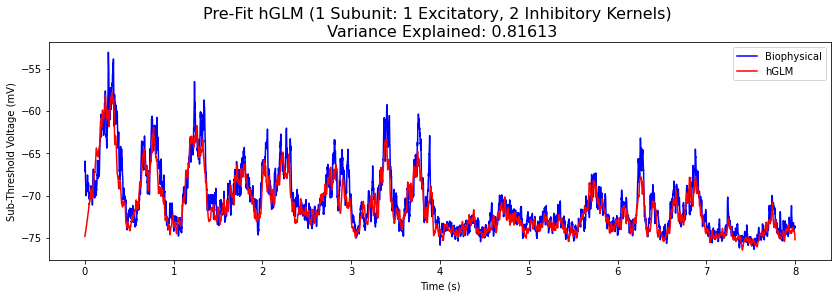

In [6]:
plt.figure(figsize = (14,4))
plt.plot(test_V_ref, label="Biophysical", c="blue")
plt.plot(test_V_final-10.45, label="hGLM", c="red")
print(np.corrcoef(test_V_ref, test_V_final)[0][1])


test_score = metrics.explained_variance_score(y_true=test_V_ref,
                                                      y_pred=test_V_final,
                                                      multioutput='uniform_average')

plt.title("Pre-Fit hGLM (1 Subunit: 1 Excitatory, 2 Inhibitory Kernels) \n Variance Explained: " + str(round(test_score, 5)), fontsize = 16)
plt.xticks(np.arange(0,8001,1000),[0,1,2,3,4,5,6,7,8])
plt.xlabel("Time (s)")
plt.ylabel("Sub-Threshold Voltage (mV)")
plt.legend()
#plt.show()


plt.savefig("/media/hdd01/sklee/hglm/biophysical/pre3_fit_test.png", dpi=150, bbox_inches='tight')

In [7]:
print(list(final_hGLM.parameters()))

[Parameter containing:
tensor([-69.], device='cuda:0', requires_grad=True), Parameter containing:
tensor([1.6063, 1.6063, 1.6063, 1.9158, 1.9158, 1.9158, 1.8308],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([4.3201], device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 0.0542,  0.0542,  0.0542, -0.0208, -0.0208, -0.0208, -0.0100],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([3.2988], device='cuda:0', requires_grad=True), Parameter containing:
tensor([2.1128], device='cuda:0', requires_grad=True)]


In [7]:
print(list(final_hGLM.parameters()))

[Parameter containing:
tensor([-68.8835], device='cuda:0', requires_grad=True), Parameter containing:
tensor([1.6063, 1.9158, 1.8307], device='cuda:0', requires_grad=True), Parameter containing:
tensor([4.3201], device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 0.0542, -0.0208, -0.0099], device='cuda:0', requires_grad=True), Parameter containing:
tensor([3.2988], device='cuda:0', requires_grad=True), Parameter containing:
tensor([2.1128], device='cuda:0', requires_grad=True)]
